In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

## 1.Description de données 'energy_antananarivo'

- **date_dep_dmd**: Date de dépôt de la demande
- **tot_nb_dmd**: Nombre total des demandes déposées
- **tot_energy**: Puissance total en KWh

Les données de la base 'energy_antananarivo' couvrent la période de janvier 2000 à décembre 2023. soit 288 années de données mensuelles.

In [2]:
df = pd.read_csv('energy_antananarivo_cleaned.csv')

### 1.1 Information supplémentaire sur le données

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date_dep_dmd  288 non-null    object 
 1   tot_nb_dmd    288 non-null    int64  
 2   tot_energy    288 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.9+ KB


On voit que la variable 'date_dep_dmd' est de type object(texte). Il faut la convertir en type Datetime pour pouvoir continuer à travailler 

In [4]:
# Conversion de date texte en datetime
from datetime import datetime

df['date_dep_dmd'] = pd.to_datetime(df['date_dep_dmd'], infer_datetime_format=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date_dep_dmd  288 non-null    datetime64[ns]
 1   tot_nb_dmd    288 non-null    int64         
 2   tot_energy    288 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 6.9 KB


Le modèle ARIMA est conçu pour les pour modéliser les séries temporelles univariées, ce qui signifie qu'il est utilisé pour analyser et prévoir des séries temporelles qui ne comportent qu'une seule variable à chaque instant de temps.  
Donc on doit supprimer une colonne de notre données et ne garder qu'une seule colonne. Etant données que nous voulions avoir une prédiction du nombre de demande, on va garder la colonne 'date_dep_dmd' et supprimer 'tot_energy'

In [6]:
df = df.drop('tot_energy', axis=1)

In [7]:
# Il est necessaire de mettre la colonne 'date_dep_dmd' en index de la table
df.set_index('date_dep_dmd', inplace=True)
df

,tot_nb_dmd
date_dep_dmd,
2000-01-01,1525
2000-02-01,1526
2000-03-01,1549
2000-04-01,1523
2000-05-01,1461
...,...
2023-08-01,2845
2023-09-01,2886
2023-10-01,2877


In [8]:
# Vérification des valeurs manqiantes
df.isnull().sum()

tot_nb_dmd    0
dtype: int64

## 2. Identification du modèle

### 2.1 Traçage du graphique de données

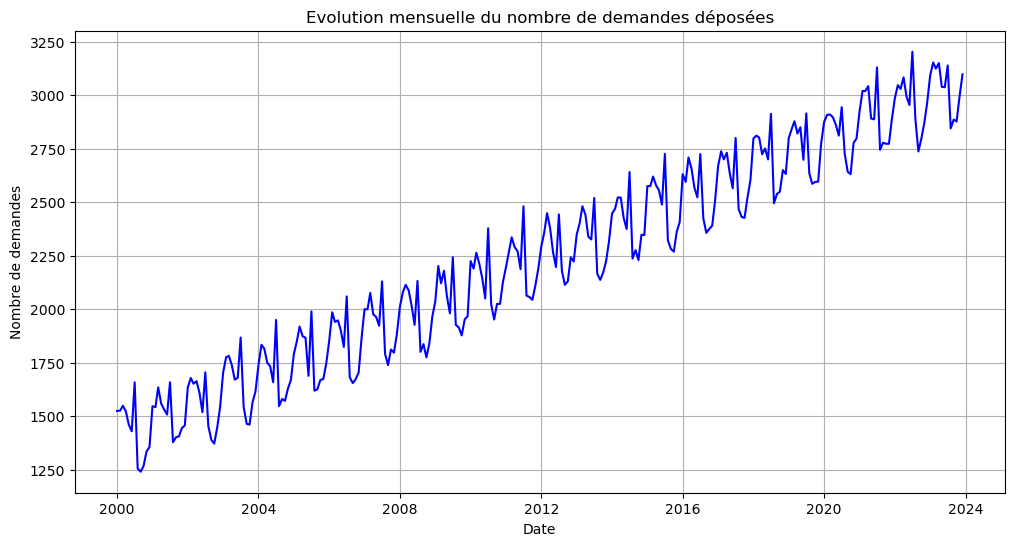

In [9]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df.tot_nb_dmd, color='blue')
plt.title('Evolution mensuelle du nombre de demandes déposées')
plt.xlabel('Date')
plt.ylabel('Nombre de demandes')
plt.grid(True)
plt.show()

D'après le grapĥique, la série temporelle n'est pas stationnaire car:

- On constate une tendance qui augmente au fil du temps
- La moyenne n'est pas constante

Autres moyens de savoir si la série est stationnaire ou pas c'est d'utiliser les ACF et PACF.  
Les graphiques ACF et PACF sont couramment utilisés pour aider à choisir les paramètres d'un modèle ARIMA en analyse de series temporelles.

Par exemple: le graphique ACF est utilisé pour identifier le terme MA(moyenne mobile) du modèle. Tandisque le graphique de PACF peut être utilisé pour identifier le terme AR(auto-regressif).

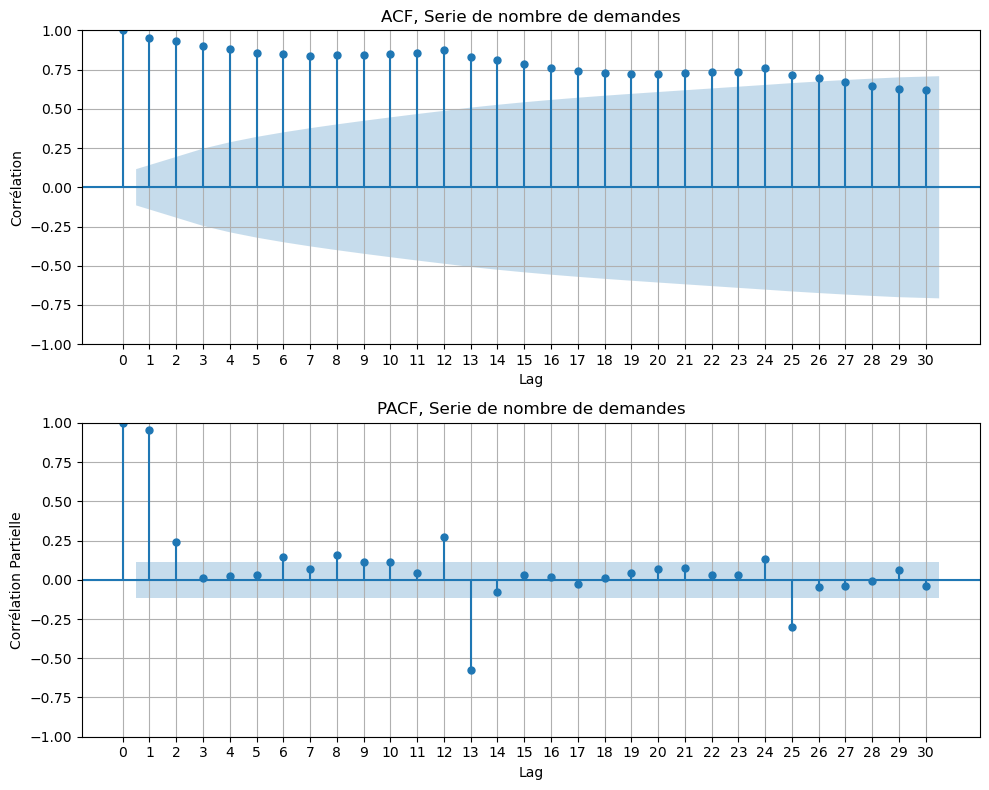

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Création des subplots 
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,8))

# Traçage l'ACF
plot_acf(df.tot_nb_dmd, lags=30, zero=True, ax=ax1)
ax1.set_title('ACF, Serie de nombre de demandes')
ax1.set_xlabel('Lag')
ax1.set_ylabel('Corrélation')
ax1.grid(True)

# Ajustement des graduations sur l'axe x pour l'ACF
ax1.set_xticks(np.arange(0,31,1))

# Traçage PACF
plot_pacf(df.tot_nb_dmd, lags=30, zero=True, ax=ax2)
ax2.set_title('PACF, Serie de nombre de demandes')
ax2.set_xlabel('Lag')
ax2.set_ylabel('Corrélation Partielle')
ax2.grid(True)

# Ajustement les graduations sur l'axe x pour le PACF
ax2.set_xticks(np.arange(0,31,1))

# Ajustement les subplots
plt.tight_layout()

plt.show()

**A propos de l'ACF**: le graphe montre qu'il y a une **decroissance regulière très lente pour la série**. Ce qui signifie déjà que la série est **non stationnaire**.

### 2.2 Analyse de la stationnarité de la variable

In [11]:

from statsmodels.tsa.stattools import adfuller
from tabulate import tabulate

# Test de Dickey-Fuller augmenté
result = adfuller(df)

# Formater les résultats dans un tableau
table = [
    ['Valeur de test', result[0]],
    ['P-valeur', result[1]],
    ['Conclusion', 'La séerie est stationnaire' if result[1] < 0.05 else 'La serie est non stationnaire']
]

print(tabulate(table, headers=['Metrique', 'Valeur'], tablefmt='github'))

| Metrique       | Valeur                        |
|----------------|-------------------------------|
| Valeur de test | -0.02861322175265248          |
| P-valeur       | 0.9561008497390386            |
| Conclusion     | La serie est non stationnaire |


**p-valeur(0.95) est supérieur à 0.05**, donc on rejette l'hypothèse nulle. Donc la série est **non stationnaire**.

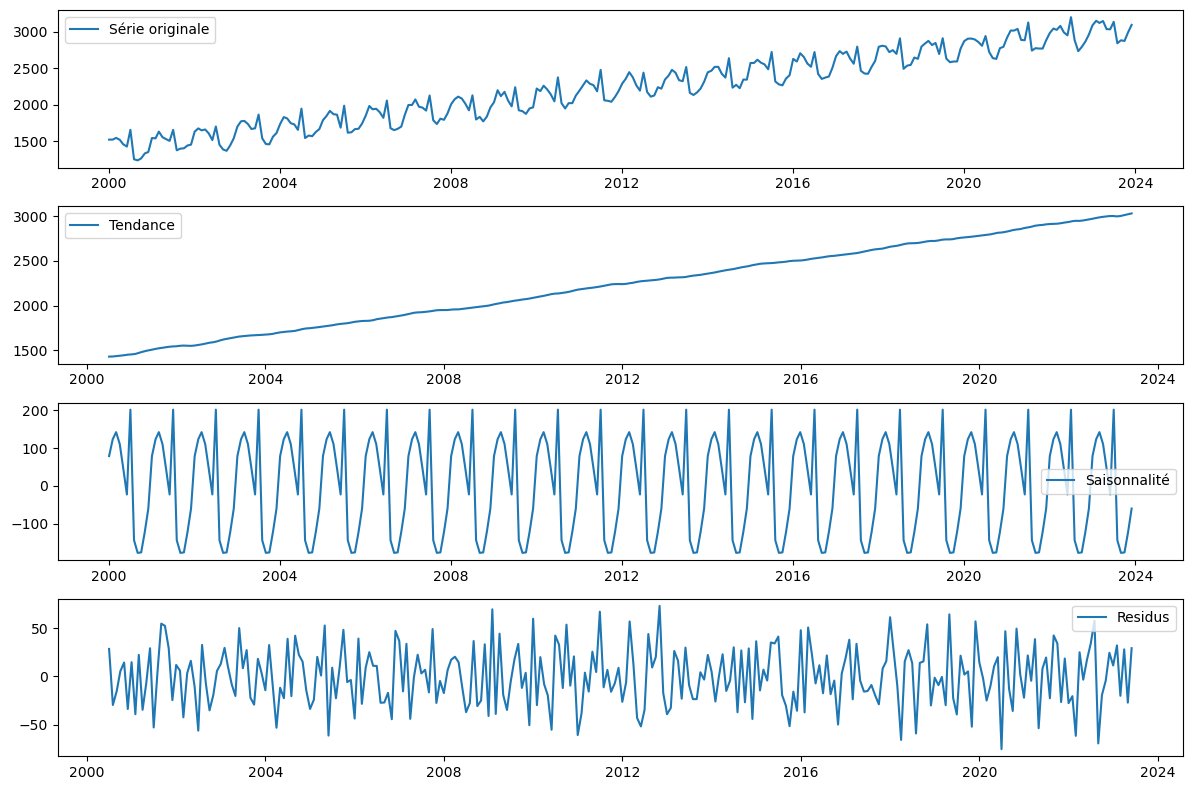

In [12]:
# Decompostion saisonnière
decomposition = seasonal_decompose(df.tot_nb_dmd, model='additive')

# Extraction des composantes de la decomposotion
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Affichage des composantes de la décomposition
plt.figure(figsize=(12,8))

plt.subplot(411)
plt.plot(df.tot_nb_dmd, label='Série originale')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Tendance')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Saisonnalité')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residus')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

Etant donnée que la serie est non stationnaire, on doit faire la différenciation pour la rendre stationnaire.

### 2.3 Différenciation(Stationnarisation) de la série

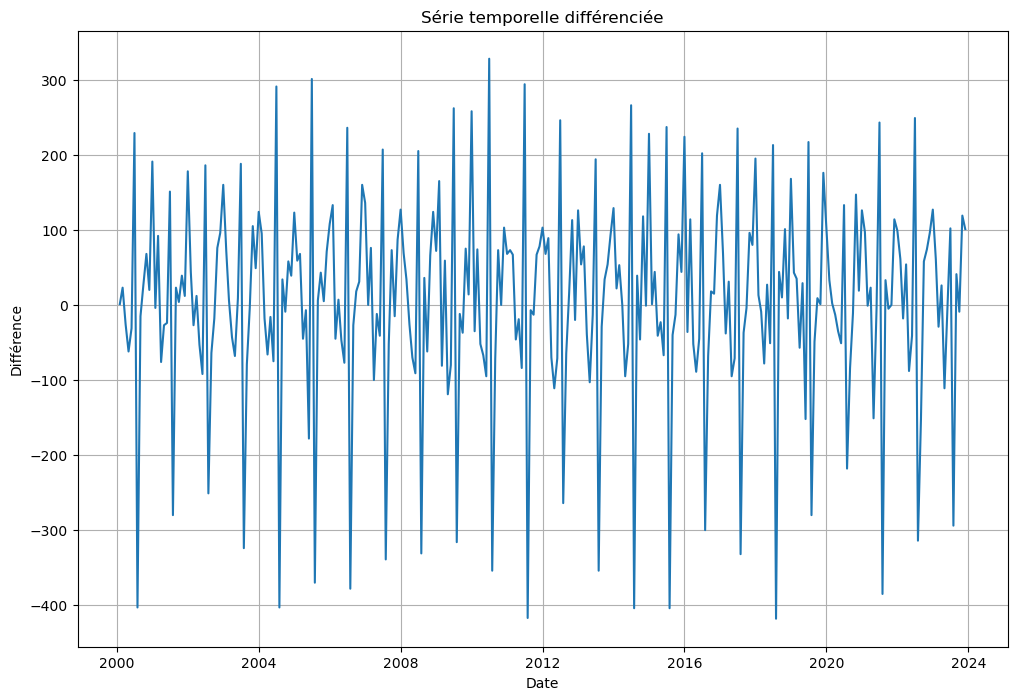

In [13]:
differenced = df.tot_nb_dmd.diff().dropna()

# Afficher la série différenciée
plt.figure(figsize=(12,8))
plt.plot(differenced)
plt.title('Série temporelle différenciée')
plt.xlabel('Date')
plt.ylabel('Différence')
plt.grid(True)
plt.show()

Malgré l'existence des variances un peu élevées, c'est beaucoup plus stationnaire que la série original.

### Retraçage de l'ACF et PACF avec la serie différenciée

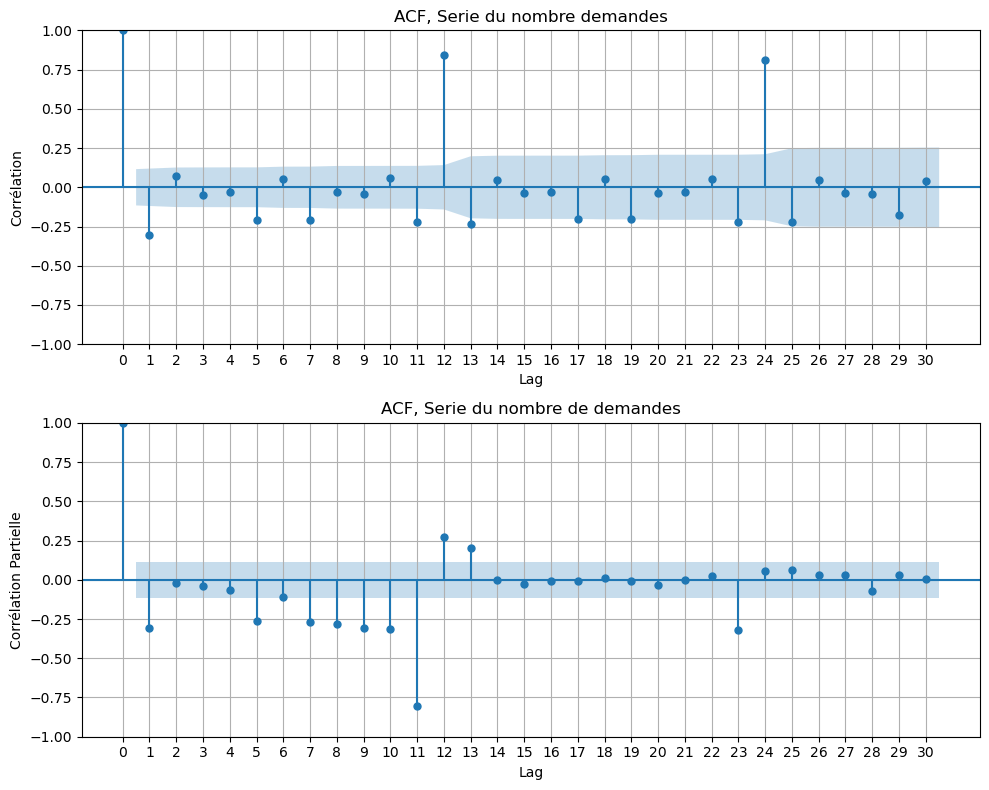

In [14]:
# Création des subplots 
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,8))

# Traçage de l'ACF
plot_acf(differenced, lags=30, zero=True, ax=ax1)
ax1.set_title('ACF, Serie du nombre demandes')
ax1.set_xlabel('Lag')
ax1.set_ylabel('Corrélation')
ax1.grid(True)

# Ajustement des graduations sur l'axe x pour l'ACF
ax1.set_xticks(np.arange(0,31,1))

# Traçage du PACF
plot_pacf(differenced, lags=30, zero=True, ax=ax2)
ax2.set_title('ACF, Serie du nombre de demandes')
ax2.set_xlabel('Lag')
ax2.set_ylabel('Corrélation Partielle')
ax2.grid(True)

# Ajustement des graduations sur l'axe x pour le PACF
ax2.set_xticks(np.arange(0,31,1))

# Ajustement des subplots
plt.tight_layout()

plt.show()

Concernant le graphe de l'ACF, le graphe montre l'absence de la décroissance lente. On peut dire que la série est maintenant stationnaire

### Analyse de la stationnarité de la variable avec la serie différenciée

In [15]:
# Test de Dickey-Fuller augmenté
result = adfuller(differenced)

# Formater les résultats dans un tableau
table = [
    ['Valeur de test', result[0]],
    ['P-valeur', result[1]],
    ['Conclusion', 'La série est stationnaire' if result[1] < 0.05 else 'La serie est non stationnaire']
]

print(tabulate(table, headers=['Metrique', 'Valeur'], tablefmt='github'))

| Metrique       | Valeur                    |
|----------------|---------------------------|
| Valeur de test | -46.29275848470029        |
| P-valeur       | 0.0                       |
| Conclusion     | La série est stationnaire |


### Identification de l'ordre de p,d,q
Pour identifier les p,q on revient dans les graphes:

- p est determiné à partir du graphe PACF:
- q est determiné à partir du graphe ACF:

In [16]:
p=2
d=1
q=1.3

In [17]:
# Separer les données en set de train et set de test
train = df.tot_nb_dmd[:-15]
test = df.tot_nb_dmd[-15:]

## 3. Estimation du modèle

In [18]:
from statsmodels.tsa.arima.model import ARIMA

### 3.1 Création d'un modèle ARIMA

In [19]:

model = ARIMA(train, order=(2,1,1))

# Ajustement du modèle
model_fit = model.fit()

# Affichage du résumé du modèle
model_fit.summary()

/home/anthony/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/anthony/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/anthony/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             tot_nb_dmd   No. Observations:                  273
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -1705.632
Date:                Fri, 08 Mar 2024   AIC                           3419.264
Time:                        20:29:21   BIC                           3433.687
Sample:                    01-01-2000   HQIC                          3425.055
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4598      0.117      3.928      0.000       0.230       0.689
ar.L2          0.1009      0.098      1.031      0.303      -0.091       0.293
ma.L1         -0.9014      0.057    -15.908      0.000      -1.012      -0.790
sigma2      1.634e+04   1903.305      8.585      0.000    1.26e+04    2.01e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 5.01
Prob(Q):                              0.74   Prob(JB):                         0.08
Heteroskedasticity (H):               1.04   Skew:                            -0.33
Prob(H) (two-sided):                  0.84   Kurtosis:                         3.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## 7. Vérification du modèle

In [20]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf

<Figure size 1200x800 with 0 Axes>

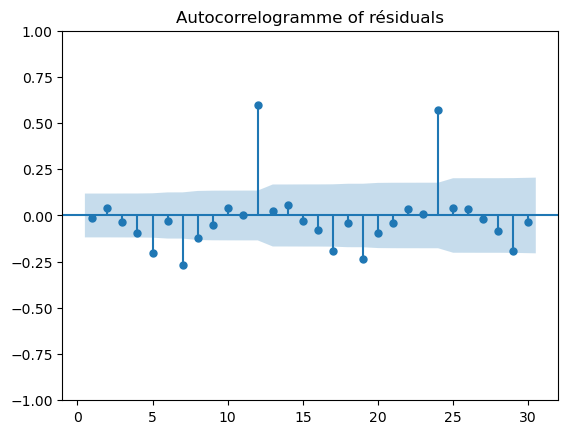

<Figure size 1200x800 with 0 Axes>

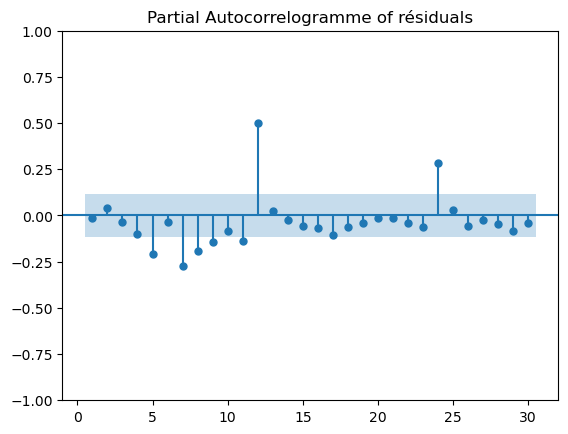

In [21]:
# calculer les résidus
residuals = model_fit.resid

# Tracer l'ACF des résidus
plt.figure(figsize=(12,8))
plot_acf(residuals, lags=30, zero=False)
plt.title('Autocorrelogramme of résiduals')
plt.show()

# Tracer la PACF des résidus
plt.figure(figsize=(12,8))
plot_pacf(residuals, lags=30, zero=False)
plt.title('Partial Autocorrelogramme of résiduals')
plt.show()

Il y a quelques pics significatives dans PACF et ACF, mais globalement, on peut dire que les résidus sont des bruits blanc parceque on est, plus ou moins dans les bons résidus. Il faut se rappeler que les bruits sont des bruits blanc s'ils se trouvent à l'intérieur des zone bleues du graphique.

## 8. Prédiction

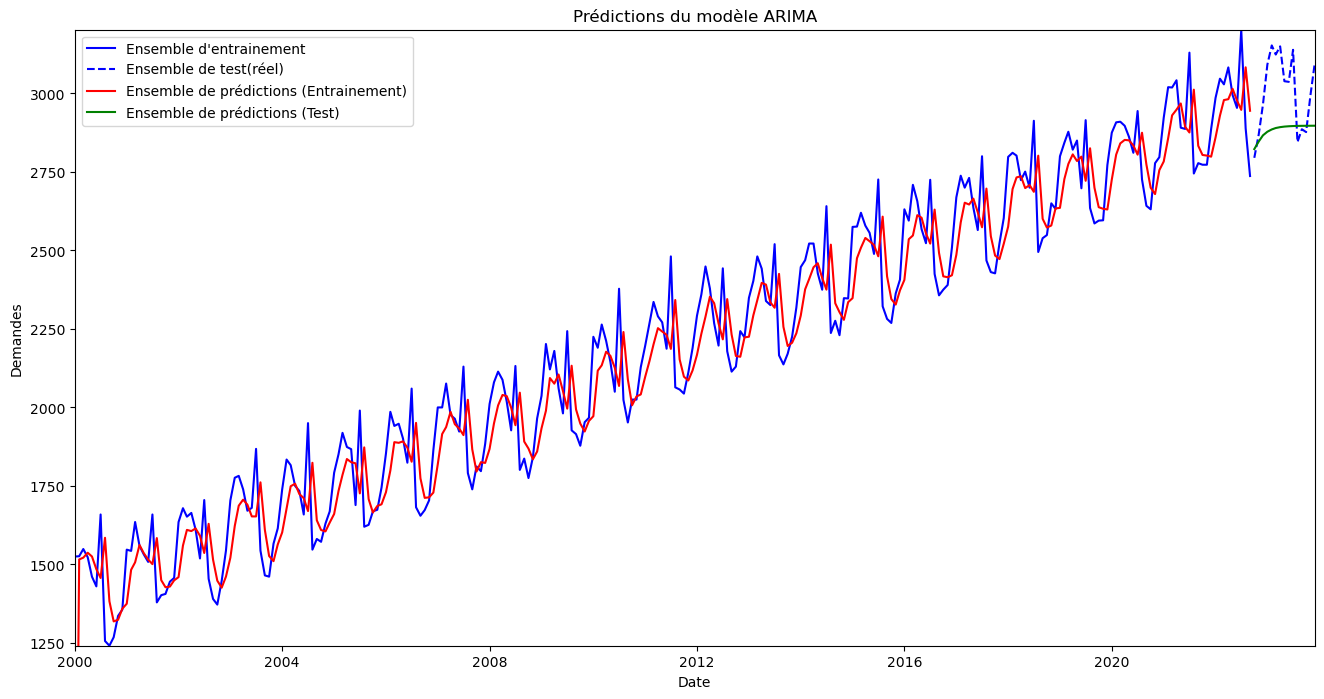

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Prédiction sur l'ensemble d'entrainement
train_prediction = model_fit.predict(start=train.index[0], end=train.index[-1])

# Prédiction sur l'ensemble de test
test_prediction = model_fit.predict(start=test.index[0], end=test.index[-1])

# Traçage des predictions et les données réels avec les courbes collées.
plt.figure(figsize=(16,8))
plt.plot(train.index, train.values, label='Ensemble d\'entrainement', color='blue')
plt.plot(test.index, test.values, label='Ensemble de test(réel)', linestyle='--', color='blue')
plt.plot(train_prediction.index, train_prediction.values, label='Ensemble de prédictions (Entrainement)', color='red')
plt.plot(test_prediction.index, test_prediction.values, label='Ensemble de prédictions (Test)', color='green')

# Définition des limites des axes x et y pour une continuté visuelle.
plt.xlim(train.index[0], test.index[-1])
plt.ylim(min(train.min(), test.min()), max(train.max(), test.max()))

plt.xlabel('Date')
plt.ylabel('Demandes')
plt.title('Prédictions du modèle ARIMA')
plt.legend()
plt.show()

D'après le graphe:

- La prédiction de l'ensemble d'entrainement est bonne; elle(rouge) suit la courbe bleu
- Mais la prédiction de l'ensemble de test(vert) n'est pas bonne

In [23]:
# Mesures de performances sur l'ensemble d'entrainement
train_mae = mean_absolute_error(train, train_prediction)
train_mse = mean_squared_error(train, train_prediction)
train_rmse = mean_squared_error(train, train_prediction, squared=False)
train_r2 = r2_score(train, train_prediction)

# Mesures de performances sur l'ensemble de test
test_mae = mean_absolute_error(test, test_prediction)
test_mse = mean_squared_error(test, test_prediction)
test_rmse = mean_squared_error(test, test_prediction, squared=False)
test_r2 = r2_score(test, test_prediction)

# Création d'un Dataframe pour afficher les mesures de performance
perf_df = pd.DataFrame({
    'Métriques:': ['MAE', 'MSE', 'RMSE', 'R²'],
    'Ensemble d\'entrainenemt:': [train_mae, train_mse, train_rmse, train_r2],
    'Ensemble de test:': [test_mae, test_mse, test_rmse, test_r2]
})

perf_df

,Métriques:,Ensemble d'entrainenemt:,Ensemble de test:
0,MAE,106.072224,135.411587
1,MSE,24817.241391,26800.950462
2,RMSE,157.534889,163.709958
3,R²,0.890114,-0.881447


On constate, d'après les mesures de métriques, que le modèle n'est pas bon

## 9. Processus de selection de modèle automatique

In [24]:
import pmdarima as pm

# Utilisation de l'auto_arima pour trouver le meilleur modèle ARIMA
model =  pm.auto_arima(train)

print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  273
Model:               SARIMAX(5, 1, 1)   Log Likelihood               -1685.854
Date:                Fri, 08 Mar 2024   AIC                           3385.708
Time:                        20:29:27   BIC                           3410.949
Sample:                    01-01-2000   HQIC                          3395.842
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3053      0.110      2.778      0.005       0.090       0.521
ar.L2          0.1505      0.100      1.511      0.131      -0.045       0.346
ar.L3         -0.0335      0.119     -0.281      0.7

Le resultat nous indique que la meilleur modèle est: SARIMAX(5, 1, 1). avec p=2, d=1, q=1

 ### 9.1 Ajustement du modèle aux données

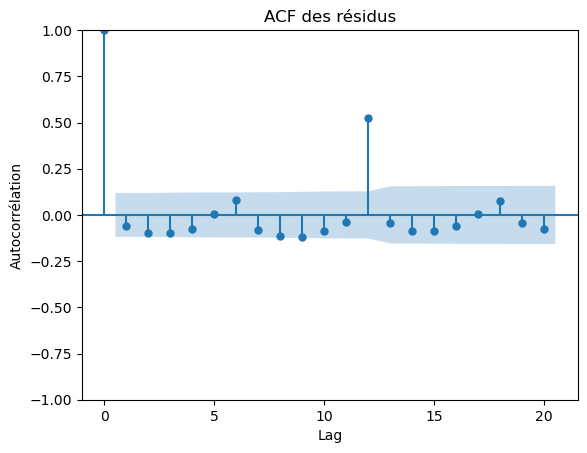

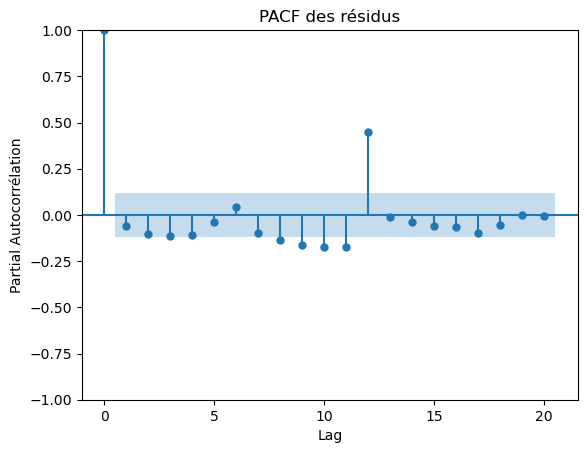

In [25]:
model.fit(train)

# Obtention des résidus du modèle
residuals = model.resid()

# Traçage de la fonction d'autocorrélation ACF des résidus
plot_acf(residuals, lags=20)
plt.xlabel('Lag')
plt.ylabel('Autocorrélation')
plt.title('ACF des résidus')
plt.show()

# Traçage de la fonction d'autocorrélation partielle PACF des résidus
plot_pacf(residuals, lags=20)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrélation')
plt.title('PACF des résidus')
plt.show()

On voit moins de pics significatifs que dans l'autre graphe. La plupart des bruits sont à l'intérieur de la zone bleue.

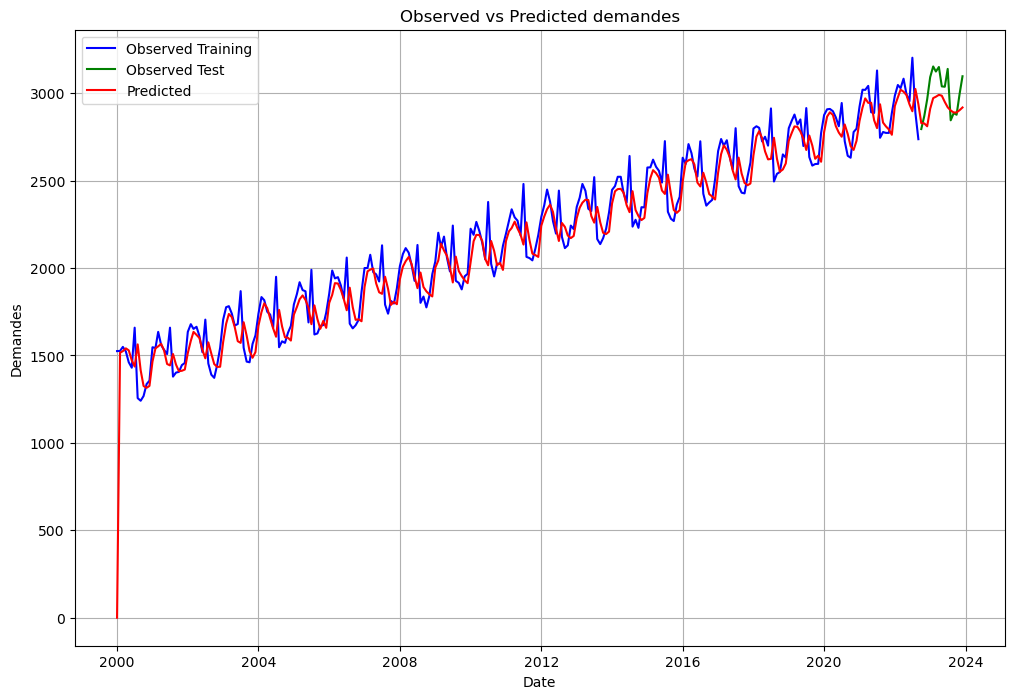

In [26]:
# Prédictions sur l'ensemble des données d'entrainement
train_pred, train_confint = model.predict_in_sample(return_conf_int=True)

# Prédictions sur l'ensemble des données de test
n_periods = len(test)
predicted ,confint = model.predict(n_periods=n_periods, return_conf_int=True)

# Concatenation des prédictions sur l'ensemble de test
all_predictions = pd.concat([pd.Series(data=train_pred, index=train.index), 
                            pd.Series(data=predicted, index=test.index)],
                           axis=0)

# Traçage des valeurs réelles et les prédictions pour l'ensemble d'entrainement et de test
plt.figure(figsize=(12,8))
plt.plot(train, label='Observed Training', color='blue')
plt.plot(test, label='Observed Test', color='green')
plt.plot(all_predictions, label='Predicted', color='red')

plt.xlabel('Date')
plt.ylabel('Demandes')
plt.title('Observed vs Predicted demandes')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
# Calcul des mesures de performance du modèle sur l'ensemble d'entrainement
train_mae = mean_absolute_error(train, train_pred)
train_mse = mean_squared_error(train, train_pred)
train_rmse = mean_squared_error(train, train_pred, squared=False)
train_r2 = r2_score(train, train_pred)

# Calcul des mesures de performance sur l'ensemble de test
test_mae = mean_absolute_error(test, predicted)
test_mse = mean_squared_error(test, predicted)
test_rmse = mean_squared_error(test, predicted, squared=False)
test_r2 = r2_score(test, predicted)

# Création d'un Dataframe pour afficher les mesures de performance
perf_df = pd.DataFrame({
    'Métriques:': ['MAE', 'MSE', 'RMSE', 'R²'],
    'Ensemble d\'entrainenemt:': [train_mae, train_mse, train_rmse, train_r2],
    'Ensemble de test:': [test_mae, test_mse, test_rmse, test_r2]
})

perf_df

,Métriques:,Ensemble d'entrainenemt:,Ensemble de test:
0,MAE,93.505998,106.635484
1,MSE,22601.148028,16055.708958
2,RMSE,150.336782,126.711124
3,R²,0.899926,-0.127123


## Ré-entrainement sur toutes les données

In [28]:
# Récupération de la totalité du Dataset
all_data = df.tot_nb_dmd

In [29]:
model =  pm.auto_arima(all_data)

In [30]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  288
Model:               SARIMAX(5, 1, 1)   Log Likelihood               -1776.162
Date:                Fri, 08 Mar 2024   AIC                           3566.324
Time:                        20:29:33   BIC                           3591.940
Sample:                    01-01-2000   HQIC                          3576.590
                         - 12-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3116      0.108      2.892      0.004       0.100       0.523
ar.L2          0.1483      0.096      1.539      0.124      -0.041       0.337
ar.L3         -0.0458      0.114     -0.401      0.688      -0.270       0.178
ar.L4         -0.1245      0.098     -1.270      0.204      -0.317       0.068
ar.L5         -0.2758      0.087     -3.168      0.002      -0.446      -0.105
ma.L1         -0.8166      0.071    -11.519      0.000      -0.956      -0.678
sigma2      1.382e+04   1494.843      9.248      0.000    1.09e+04    1.68e+04
===================================================================================
Ljung-Box (L1) (Q):                   2.44   Jarque-Bera (JB):                14.85
Prob(Q):                              0.12   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                             0.33
Prob(H) (two-sided):                  0.89   Kurtosis:                         3.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [31]:
final_model = model.fit(all_data)

In [32]:
# Exemple de prévision dans le future
forecast = final_model.predict(n_periods=12)  # Exemple de prévision pour les 12 prochains mois

# Affichez les prédictions
forecast

2024-01-01    3119.376082
2024-02-01    3125.681983
2024-03-01    3113.999815
2024-04-01    3064.877358
2024-05-01    3016.912495
2024-06-01    2988.264411
2024-07-01    2974.194181
2024-08-01    2977.099186
2024-09-01    2996.749848
2024-10-01    3020.742259
2024-11-01    3040.650129
2024-12-01    3053.027798
Freq: MS, dtype: float64

In [33]:
def forcast(model, data):
    target_datetime = pd.to_datetime(data['date'], format='%d-%m-%Y')

    # Trouver le dernier index de la série temporelle
    last_index = all_data.index[-1]

    # Calculer le nombre de steps entre le dernier index et la date donnée
    steps = int((target_datetime - last_index).days / 30)

    # Faire une prédiction avec le modèle ARIMA pour les steps donnés
    prediction = model.predict(steps=steps)[0]  # Nous utilisons [0] car la fonction forecast retourne un tuple (array, stderr, conf_int)

    return prediction

In [34]:
import joblib
joblib.dump(final_model, 'deploy/final_model.pkl')

['deploy/final_model.pkl']